<a href="https://colab.research.google.com/github/codermine29/nifty/blob/main/Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install any libraries that might not be present in Colab
!pip install yfinance beautifulsoup4 requests lxml

# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import datetime
import time
import os


In [2]:
# Define the ticker symbols and date range
tickers = {
    'Nifty50': '^NSEI',
    'NiftyMidcap100': '^CNXMDT',
    'IndiaVIX': '^INDIAVIX'
}

# Set date range: 5 years back from today
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=5*365)

# Function to fetch and store historical data
nifty_data = {}
for name, symbol in tickers.items():
    data = yf.download(symbol, start=start_date, end=end_date)
    data.dropna(inplace=True)
    data.reset_index(inplace=True)
    nifty_data[name] = data
    print(f"{name} data collected: {len(data)} rows")

# Example: display first 5 rows of Nifty 50
nifty_data['Nifty50'].head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Nifty50 data collected: 1236 rows


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMDT']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^INDIAVIX']: YFInvalidPeriodError("^INDIAVIX: Period 'max' is invalid, must be of the format 1d, 5d, etc.")


NiftyMidcap100 data collected: 0 rows
IndiaVIX data collected: 0 rows


Price,Date,Close,High,Low,Open,Volume
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
0,2020-03-24,7801.049805,8036.950195,7511.100098,7848.299805,738400
1,2020-03-25,8317.849609,8376.750000,7714.750000,7735.149902,736900
2,2020-03-26,8641.450195,8749.049805,8304.900391,8451.000000,865600
3,2020-03-27,8660.250000,9038.900391,8522.900391,8949.099609,801500
4,2020-03-30,8281.099609,8576.000000,8244.000000,8385.950195,593300


In [3]:
# Updated tickers
tickers = {
    'Nifty50': '^NSEI',
    'NiftyMidcap100': '^NSEMIDCAP100',
    'IndiaVIX': 'INDIAVIX.NS'
}

# Date range
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=5*365)

# Download data with error handling
nifty_data = {}
for name, symbol in tickers.items():
    try:
        data = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)
        if not data.empty:
            data.dropna(inplace=True)
            data.reset_index(inplace=True)
            nifty_data[name] = data
            print(f"{name} data collected: {len(data)} rows")
        else:
            print(f"{name} data is empty.")
    except Exception as e:
        print(f"Failed to download {name}: {e}")


[*********************100%***********************]  1 of 1 completed


Nifty50 data collected: 1236 rows


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMIDCAP100']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INDIAVIX.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-03-24 21:31:39.619611 -> 2025-03-23 21:31:39.619611)')


NiftyMidcap100 data is empty.
IndiaVIX data is empty.


In [4]:
# Required libraries
!pip install fake_useragent

import requests
from fake_useragent import UserAgent

# Use fake user-agent to mimic a browser
headers = {
    "User-Agent": UserAgent().chrome,
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive"
}

# Start a session with NSE (they require this)
session = requests.Session()
session.get("https://www.nseindia.com", headers=headers)  # Homepage request to set cookies


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 9.3 MB/s eta 0:00:00


<Response [200]>

In [10]:
# Assuming you already have this:
nifty_df = nifty_data['Nifty50'].copy()

# Calculate daily returns
nifty_df['Return'] = nifty_df['Close'].pct_change()

# Calculate 30-day rolling volatility (standard deviation)
nifty_df['30D_Volatility'] = nifty_df['Return'].rolling(window=30).std()

# Drop NA rows caused by rolling window
nifty_df.dropna(inplace=True)

# Display last few rows
nifty_df[['Date', 'Close', 'Return', '30D_Volatility']].tail()


Price,Date,Close,Return,30D_Volatility
Ticker,,^NSEI,,
1231,2025-03-17,22508.750000,0.004981,0.007040
1232,2025-03-18,22834.300781,0.014463,0.007261
1233,2025-03-19,22907.599609,0.003210,0.007227
1234,2025-03-20,23190.650391,0.012356,0.006948
1235,2025-03-21,23350.400391,0.006889,0.007083


In [11]:
# FII/DII endpoint (from browser network tab)
fii_url = "https://www.nseindia.com/api/fiidiiTradeHistory?section=EQ"

# Make request
fii_response = session.get(fii_url, headers=headers)

if fii_response.status_code == 200:
    fii_json = fii_response.json()
    fii_df = pd.DataFrame(fii_json['data'])

    # Clean columns
    fii_df = fii_df.rename(columns={
        'buyValue': 'Buy',
        'sellValue': 'Sell',
        'netValue': 'Net',
        'fiiDii': 'Type',
        'tradeDate': 'Date'
    })

    # Convert data types
    fii_df['Date'] = pd.to_datetime(fii_df['Date'])
    for col in ['Buy', 'Sell', 'Net']:
        fii_df[col] = pd.to_numeric(fii_df[col].str.replace(',', ''), errors='coerce')

    # Pivot to get FII and DII in separate columns
    fii_pivot = fii_df.pivot(index='Date', columns='Type', values=['Buy', 'Sell', 'Net']).sort_index()

    # Flatten multi-index columns
    fii_pivot.columns = ['_'.join(col).strip() for col in fii_pivot.columns.values]
    fii_pivot.reset_index(inplace=True)

    # Add FII/DII ratio
    fii_pivot['FII_DII_Ratio'] = fii_pivot['Net_FII'] / (fii_pivot['Net_DII'] + 1e-9)

    print("✅ FII/DII data fetched and processed")
    display(fii_pivot.tail())
else:
    print("❌ Failed to fetch FII/DII data:", fii_response.status_code)


❌ Failed to fetch FII/DII data: 404


In [12]:
# Simulated repo rate data for last 12 months (replace this with scraped data later)
repo_data = {
    'Date': pd.date_range(start="2023-03-01", periods=12, freq='M'),
    'Repo Rate': [6.50, 6.50, 6.50, 6.50, 6.50, 6.50, 6.50, 6.50, 6.50, 6.50, 6.50, 6.50]
}

repo_df = pd.DataFrame(repo_data)

# Display
repo_df.tail()


<ipython-input-12-5243e80f50d4>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Date': pd.date_range(start="2023-03-01", periods=12, freq='M'),


,Date,Repo Rate
7,2023-10-31,6.5
8,2023-11-30,6.5
9,2023-12-31,6.5
10,2024-01-31,6.5
11,2024-02-29,6.5


In [15]:
print(nifty_df.columns)


MultiIndex([(          'Date',      ''),
            (         'Close', '^NSEI'),
            (          'High', '^NSEI'),
            (           'Low', '^NSEI'),
            (          'Open', '^NSEI'),
            (        'Volume', '^NSEI'),
            (        'Return',      ''),
            ('30D_Volatility',      ''),
            (         'Month',      '')],
           names=['Price', 'Ticker'])


In [16]:
# Flatten the MultiIndex into single-level column names
nifty_df.columns = ['_'.join([str(i) for i in col if i]) for col in nifty_df.columns]


In [18]:
print(merged_df.columns.tolist())


['Date', 'Close_^NSEI', 'High_^NSEI', 'Low_^NSEI', 'Open_^NSEI', 'Volume_^NSEI', 'Return', '30D_Volatility', 'Repo Rate']


In [19]:
# Replace with actual column name from the print above
merged_df[['Date', 'Close_^NSEI', 'High_^NSEI', 'Low_^NSEI', 'Open_^NSEI', 'Volume_^NSEI', 'Return', '30D_Volatility', 'Repo Rate']].tail()


,Date,Close_^NSEI,High_^NSEI,Low_^NSEI,Open_^NSEI,Volume_^NSEI,Return,30D_Volatility,Repo Rate
1201,2025-03-17,22508.750000,22577.000000,22353.150391,22353.150391,251100,0.004981,0.007040,NaN
1202,2025-03-18,22834.300781,22857.800781,22599.199219,22662.250000,272600,0.014463,0.007261,NaN
1203,2025-03-19,22907.599609,22940.699219,22807.949219,22874.949219,324000,0.003210,0.007227,NaN
1204,2025-03-20,23190.650391,23216.699219,22973.949219,23036.599609,313700,0.012356,0.006948,NaN
1205,2025-03-21,23350.400391,23402.699219,23132.800781,23168.250000,541000,0.006889,0.007083,NaN


In [22]:
# Step 1: Copy merged dataset
model_df = merged_df.copy()

# Step 2: Forward-fill missing repo rate values (updated method)
model_df['Repo Rate'] = model_df['Repo Rate'].ffill()

# Step 3: Normalize Volatility
if model_df['30D_Volatility'].max() != model_df['30D_Volatility'].min():
    model_df['Vol_Score'] = (model_df['30D_Volatility'] - model_df['30D_Volatility'].min()) / \
                            (model_df['30D_Volatility'].max() - model_df['30D_Volatility'].min())
else:
    model_df['Vol_Score'] = 0.5  # fallback if constant

# Step 4: Normalize Repo Rate (inverted logic: higher rate = lower score)
if model_df['Repo Rate'].max() != model_df['Repo Rate'].min():
    model_df['Repo_Score'] = 1 - (model_df['Repo Rate'] - model_df['Repo Rate'].min()) / \
                                (model_df['Repo Rate'].max() - model_df['Repo Rate'].min())
else:
    model_df['Repo_Score'] = 0.5  # fallback if constant

# Step 5: Compute Liquidity Score (weighted sum)
w_vol = 0.6
w_repo = 0.4
model_df['Liquidity_Score'] = (w_vol * model_df['Vol_Score']) + (w_repo * model_df['Repo_Score'])

# Step 6: Risk tolerance setting
risk_setting = 'medium'  # options: 'low', 'medium', 'high'
base_cash = {'low': 0.1, 'medium': 0.2, 'high': 0.3}[risk_setting]

# Step 7: Final cash allocation percentage
model_df['Cash_Allocation_%'] = base_cash + model_df['Liquidity_Score'] * (1 - base_cash)
model_df['Cash_Allocation_%'] = model_df['Cash_Allocation_%'].clip(0, 1)

# Step 8: Show result
model_df[['Date', '30D_Volatility', 'Repo Rate', 'Liquidity_Score', 'Cash_Allocation_%']].tail()


,Date,30D_Volatility,Repo Rate,Liquidity_Score,Cash_Allocation_%
1201,2025-03-17,0.007040,6.5,0.264717,0.411773
1202,2025-03-18,0.007261,6.5,0.269644,0.415715
1203,2025-03-19,0.007227,6.5,0.268898,0.415119
1204,2025-03-20,0.006948,6.5,0.262688,0.410151
1205,2025-03-21,0.007083,6.5,0.265685,0.412548


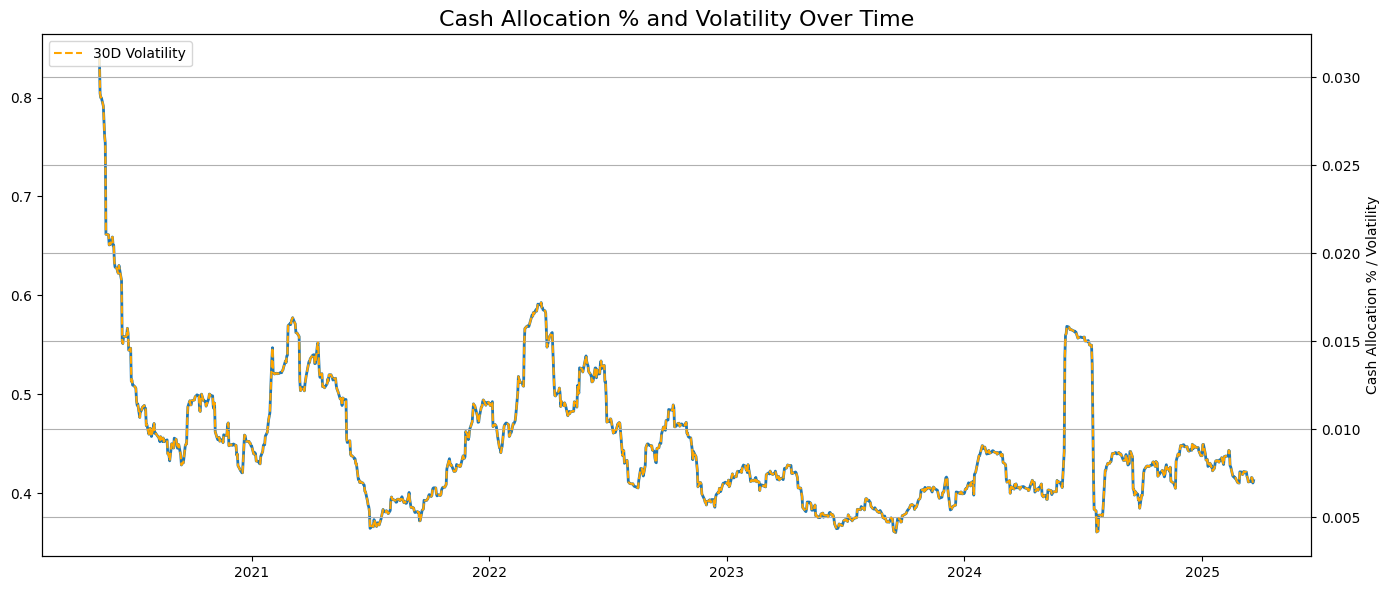

In [23]:
import matplotlib.pyplot as plt

# Plot Cash Allocation % over time
plt.figure(figsize=(14, 6))
plt.plot(model_df['Date'], model_df['Cash_Allocation_%'], label='Cash Allocation %', linewidth=2)

# Optional: overlay volatility on secondary y-axis
plt.twinx()
plt.plot(model_df['Date'], model_df['30D_Volatility'], color='orange', linestyle='--', label='30D Volatility')

# Formatting
plt.title('Cash Allocation % and Volatility Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Cash Allocation % / Volatility')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
# Save raw Nifty 50 data
nifty_data['Nifty50'].to_csv("nifty50_raw.csv", index=False)

# Save mock repo rate data
repo_df.to_csv("repo_rate_data.csv", index=False)

# Save final merged + scored dataset
model_df.to_csv("cash_allocation_output.csv", index=False)

print("✅ Files saved in current working directory.")


✅ Files saved in current working directory.


In [25]:
from google.colab import files
files.download("cash_allocation_output.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>